# Notebook to visualize all the tissues and labels of the mask

### Label = 0
Background

### Necrotic and Non-Enhancing Tumor Core (Label = 1) (NCR NET)
- The necrotic part is the dead tissue in the center of the tumor, caused by poor blood supply.
- The non-enhancing part is tumor tissue that does not take up contrast agent (on T1ce MRI), meaning the blood–brain barrier there is intact or the tissue is non-viable.

Appearance:
- On T1ce (contrast-enhanced) MRI → Dark (no enhancement)
- On T2/FLAIR → Can appear bright or heterogeneous
- It’s the “core” of the tumor that doesn’t light up even after contrast injection.

Indicates old or dead tumor regions, not actively growing. Often sits in the center, surrounded by the enhancing rim. As the brain tumor grows, it becomes dense and metabolically active. the inner regions of the timor outgrow their blood suply (they are too far from capillaries to get enough oxygen)

### Peritumoral Edema (Label = 2)
- Swelling or fluid accumulation around the tumor. Caused by the tumor disrupting the blood–brain barrier and leaking fluid into the surrounding brain tissue.

Appearance:
- On FLAIR/T2 → Very bright (hyperintense)
- On T1ce → Usually dark or grayish (no enhancement)

Not tumor cells themselves, but swollen brain tissue affected by the tumor’s presence. Important for surgical planning and radiotherapy margins.

### Label = 3
corresponds to a class no longer used but the number is still "active yet unused" for compatibility reasons with old code

### Enhancing Tumor (Label = 4)
- Active tumor tissue that takes up the contrast agent on T1ce images.
- Indicates areas where the blood–brain barrier is disrupted and tumor cells are actively growing or invading.

Appearance:
- On T1ce → Bright or white (strong enhancement)
- On FLAIR/T2 → Often also bright but less distinct than in T1ce

The most aggressive and clinically significant part of the tumor. Often forms a bright ring or patch around the necrotic core.

### Separation task:
Whole tumor (WT): all labels (1 + 2 + 4)

Tumor core (TC): only labels 1 + 4

Enhancing tumor (ET): label 4 only

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os

In [2]:
import subprocess

try:
    subprocess.run(['bash', 'mount_usb.sh'], check=True)
    print("Mount succeeded via bash script!")
except subprocess.CalledProcessError as e:
    print("Mount failed:", e)


Mount succeeded via bash script!


In [41]:
def get_path(root = "/mnt/d/MICCAI_BraTS_2020/BraTS20_Training_", patient='001', type="t1ce", mask="seg", extension=".nii"): # SET PATH

    image_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + type + extension)
    mask_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + mask + extension)

    print("Loading image NIfTI file from:", image_path)
    print("Loading mask NIfTI file from:", mask_path)
    
    return image_path, mask_path

def load_brain(image_path, mask_path): # FIRST LOAD FILE AND THEN GET DATA
    # Load NIfTI files
    img = nib.load(image_path)
    mask_img = nib.load(mask_path)

    # Get data arrays
    data = img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    print(f"Volume shape: {data.shape}")
    print(f"Mask shape: {mask_data.shape}")
    return data, mask_data

def slice_axial(data, mask_data, slice_index): # SLICE
    slice_img = data[:, :, slice_index]
    slice_mask = mask_data[:, :, slice_index]
    print(f"Showing axial slice index: {slice_index}")
    return slice_img, slice_mask

def plot_labels (patient, slice_num, slice_img, slice_mask):

    hex_colors = {
        0: "#aca9c5",   # blue
        1: "#000000",   # black
        2: "#89e6ad",   # green
        4: "#d62728"    # red
    }

    # Find unique labels present in the current slice mask
    present_labels = np.unique(slice_mask).astype(int)

    # create colormap: include placeholder for label 3
    custom_cmap = ListedColormap([hex_colors.get(i, "#ffffff") for i in range(5)])

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(slice_img.T, cmap='gray', origin='lower')
    axs[0].set_title("T1ce Slice")

    axs[1].imshow(slice_img.T, cmap='gray', origin='lower')
    axs[1].imshow(slice_mask.T, cmap=custom_cmap, alpha=0.4, origin='lower')
    axs[1].set_title("T1ce + Segmentation Overlay")
    
    # Modify suptitle to include present labels
    if present_labels.size > 1:
        labels_info = f"Present Labels: {', '.join(map(str, sorted(present_labels)))}"
    else:
        labels_info = "No tumor/lesion labels (1, 2, or 4) present"

    plt.suptitle(
        f"Patient: {patient}, Slice: {slice_num}\n{labels_info}",
        fontsize=12 # Decreased font size to accommodate two lines
    )

    # ---- Custom legend with HEX colors ----
    legend_labels = {
        "0 - Background": hex_colors[0],
        "1 - Necrotic core": hex_colors[1],
        "2 - Edema": hex_colors[2],
        "4 - Enhancing tumor": hex_colors[4]
    }

    patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]

    plt.legend(
        handles=patches,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        facecolor='white',
        edgecolor='black'
    )

    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust tight_layout to make space for the two-line suptitle
    plt.show()


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_001/BraTS20_Training_001_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 49


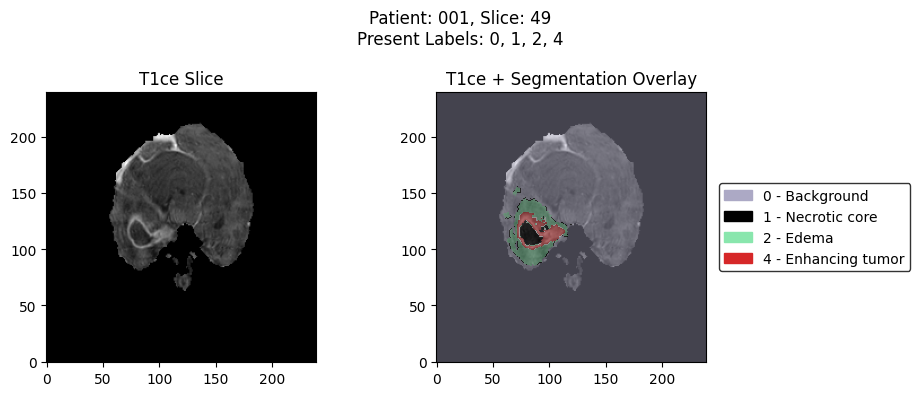

In [42]:
patient='001'
slice_index = 49

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_003/BraTS20_Training_003_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 69


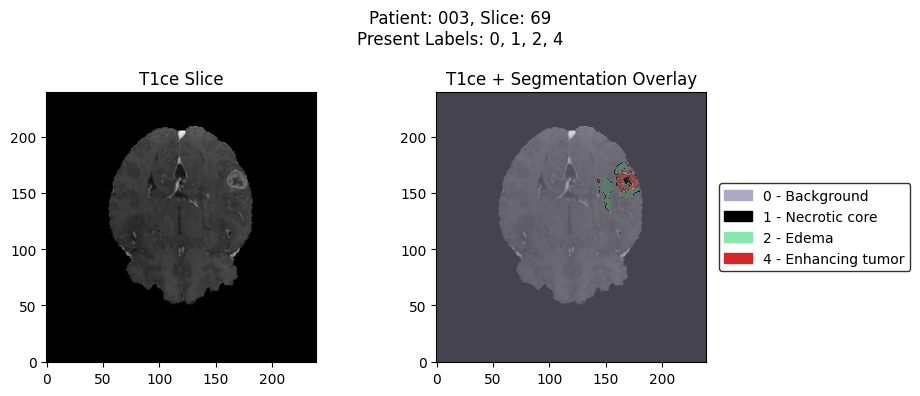

In [43]:
patient='003'
slice_index = 69

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_349/BraTS20_Training_349_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_349/BraTS20_Training_349_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 99


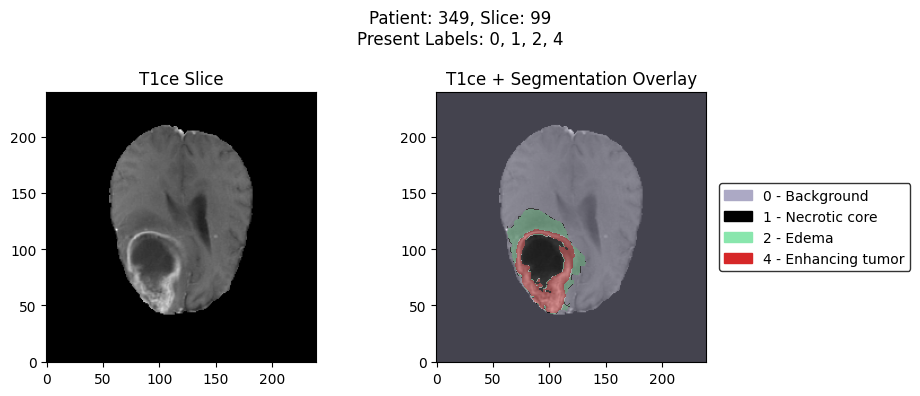

In [44]:
patient='349'
slice_index = 99

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_362/BraTS20_Training_362_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_362/BraTS20_Training_362_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 68


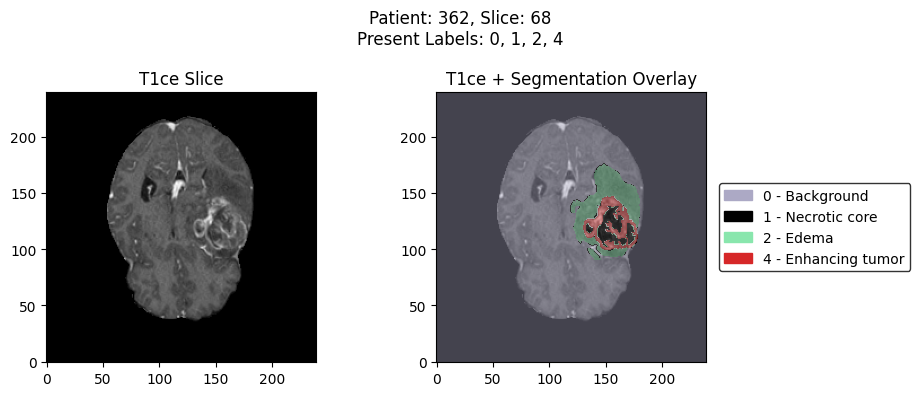

In [45]:
patient='362'
slice_index = 68

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_234/BraTS20_Training_234_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_234/BraTS20_Training_234_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 39


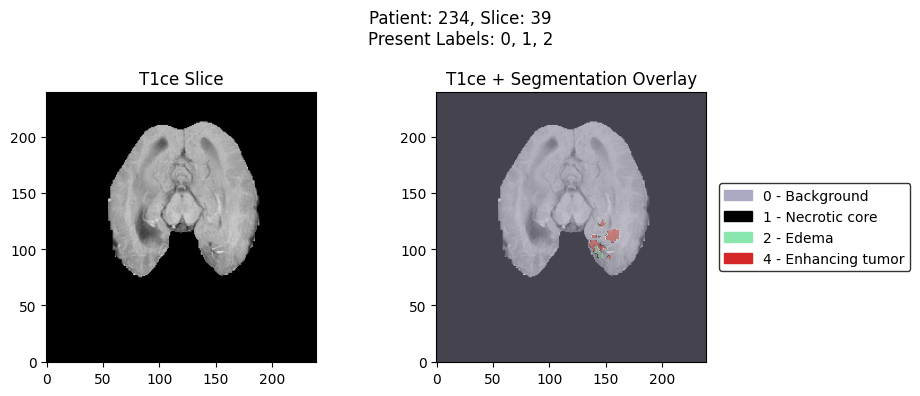

In [46]:
patient='234'
slice_index = 39

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_162/BraTS20_Training_162_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_162/BraTS20_Training_162_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 106


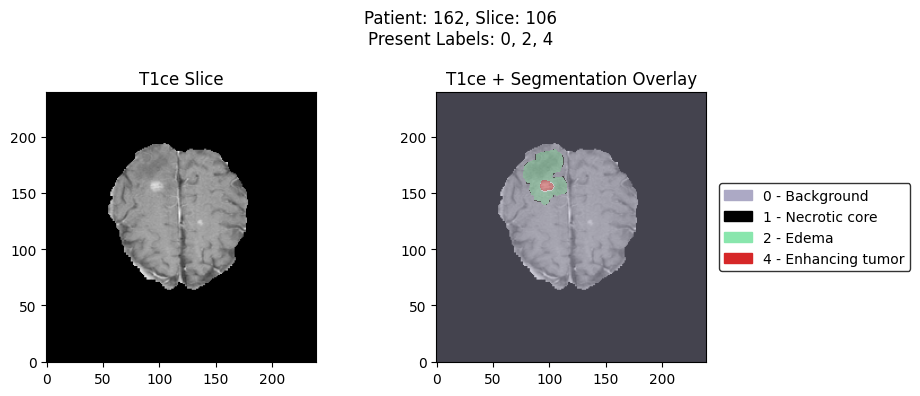

In [47]:
patient='162'
slice_index = 106

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_187/BraTS20_Training_187_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_187/BraTS20_Training_187_seg.nii
Volume shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Showing axial slice index: 122


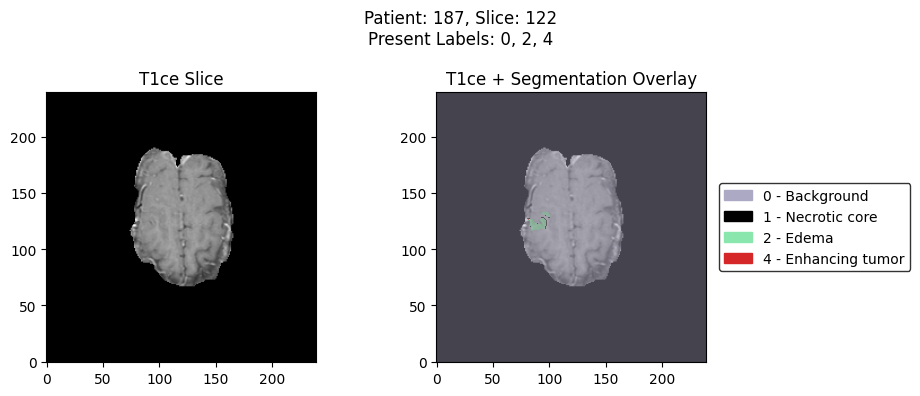

In [48]:
patient='187'
slice_index = 122

image_path, mask_path = get_path(patient = patient)
data, mask_data = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(data, mask_data, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

## UNMOUNT:

In [ ]:
import subprocess

print("--- Running Unmount Script ---")
try:
    subprocess.run(['bash', 'unmount_usb.sh'], check=True)
    print("SUCCESS: USB drive unmounted from /mnt/d")
except subprocess.CalledProcessError as e:
    print(f"ERROR: Unmount failed: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


EXTRA CODE I MIGHT NEED